In [1]:
from IPython.display import SVG
import numpy as np
from scipy import sparse
from scipy.cluster.hierarchy import dendrogram, linkage
from sknetwork.data import from_edge_list, load_netset
from sknetwork.ranking import PageRank, top_k
from sknetwork.embedding import Spectral
from sknetwork.clustering import Louvain
from sknetwork.classification import DiffusionClassifier
from sknetwork.utils import get_neighbors
from sknetwork.visualization import visualize_graph, visualize_bigraph, visualize_dendrogram

In [2]:
# Load the Wikivitals dataset
wikivitals = load_netset('wikivitals')
adjacency = wikivitals.adjacency
labels = wikivitals.labels
names = wikivitals.names
names_labels = wikivitals.names_labels

Parsing files...
Done.


In [3]:
adjacency # make sure the adjacency matrix is a csr sparse matrix

<Compressed Sparse Row sparse matrix of dtype 'bool'
	with 824999 stored elements and shape (10011, 10011)>

In [4]:
print(names_labels) # Print the main labels (categories) of the dataset

['Arts' 'Biological and health sciences' 'Everyday life' 'Geography'
 'History' 'Mathematics' 'People' 'Philosophy and religion'
 'Physical sciences' 'Society and social sciences' 'Technology']


In [5]:
label_id = {name: i for i, name in enumerate(names_labels)} # Create a mapping from label names to indices
print(list(label_id.items())[:3]) # Print the first three label mappings

[(np.str_('Arts'), 0), (np.str_('Biological and health sciences'), 1), (np.str_('Everyday life'), 2)]


In [6]:
i = 10000
print(f"Name no. {i}: ", names[i])
print("Label no. ", labels[i])
print("Label name: ", names_labels[labels[i]])

Name no. 10000:  Édouard Manet
Label no.  6
Label name:  People


In [7]:
neighbors = get_neighbors(adjacency, i)
print(f"Neighbors of {names[i]}: ", names[neighbors[:10]])

Neighbors of Édouard Manet:  ['Adolphe Thiers' 'American Civil War' 'Bordeaux' 'Camille Pissarro'
 'Carmen' 'Charles Baudelaire' 'Claude Monet' 'Diego Velázquez'
 'Edgar Allan Poe' 'Edgar Degas']


In [8]:
pagerank = PageRank()
n_selection = 50
selection = []
for label in np.arange(len(names_labels)):
    ppr = pagerank.fit_predict(adjacency, weights=(labels==label))
    scores = ppr * (labels == label)
    selection.append(top_k(scores, n_selection))
selection = np.array(selection)

In [9]:
selection.shape

(11, 50)

In [10]:
for label, name_label in enumerate(names_labels):
    print("-"*10)
    print(label, name_label)
    print(names[selection[label,:5]])

----------
0 Arts
['Encyclopædia Britannica' 'Romanticism' 'Jazz' 'Modernism' 'Baroque']
----------
1 Biological and health sciences
['Taxonomy (biology)' 'Animal' 'Chordate' 'Plant' 'Species']
----------
2 Everyday life
['Olympic Games' 'Association football' 'Basketball' 'Baseball' 'Softball']
----------
3 Geography
['Geographic coordinate system' 'United States' 'China' 'France' 'India']
----------
4 History
['World War II' 'World War I' 'Roman Empire' 'Ottoman Empire'
 'Middle Ages']
----------
5 Mathematics
['Real number' 'Function (mathematics)' 'Complex number'
 'Set (mathematics)' 'Integer']
----------
6 People
['Aristotle' 'Plato' 'Augustine of Hippo' 'Winston Churchill'
 'Thomas Aquinas']
----------
7 Philosophy and religion
['Christianity' 'Islam' 'Buddhism' 'Hinduism' 'Catholic Church']
----------
8 Physical sciences
['Oxygen' 'Hydrogen' 'Earth' 'Kelvin' 'Density']
----------
9 Society and social sciences
['The New York Times' 'Latin' 'English language' 'French language'
 '

## Embedding

In [11]:
n_components = 20
spectral = Spectral(n_components=n_components)
embeddings = spectral.fit_transform(adjacency)
embeddings.shape

(10011, 20)

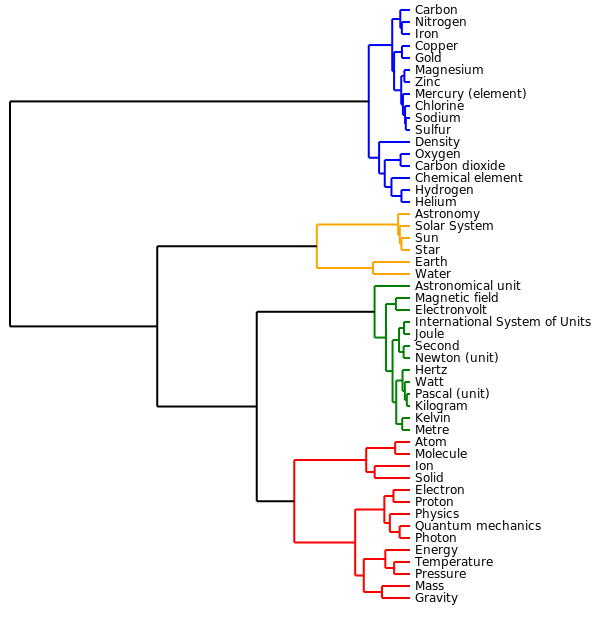

In [12]:
label = label_id['Physical sciences']
index = selection[label]
dendrogram_articles = linkage(embeddings[index], method='ward')
img = visualize_dendrogram(dendrogram_articles, names[index], rotate=True, scale = 2, width=200, n_clusters=4)
SVG(img)

## Clustering

In [13]:
algorithm = Louvain()
clusters = algorithm.fit_predict(adjacency)
n_clusters = len(set(clusters))
print(n_clusters)

9


In [14]:
np.unique(clusters, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([1836, 1800, 1315, 1262, 1225, 1067,  804,  672,   30]))

In [15]:
n_selection = 10
selection = []

for cluster in np.arange(len(set(clusters))):
    ppr = pagerank.fit_predict(adjacency, weights=(clusters==cluster)) # Boolean weights based on whether node is in cluster
    scores = ppr * (clusters == cluster) # Mask scores to only consider nodes in cluster
    selection.append(top_k(scores, n_selection)) # Select top n_selection nodes in cluster based on scores
selection = np.array(selection)

In [16]:
# Print the selected top articles in each cluster
for i in np.arange(len(set(clusters))):
    print("-"*10)
    print("Cluster no. ", i)
    print(names[selection[i]])

----------
Cluster no.  0
['Physics' 'Hydrogen' 'Oxygen' 'Kelvin' 'Albert Einstein'
 'Quantum mechanics' 'Electron' 'Real number' 'Density' 'Energy']
----------
Cluster no.  1
['Taxonomy (biology)' 'Animal' 'Plant' 'Protein' 'Species' 'Chordate'
 'Bacteria' 'Permian' 'Cambrian' 'Jurassic']
----------
Cluster no.  2
['Latin' 'World War I' 'Roman Empire' 'Middle Ages' 'Greek language'
 'London' 'Paris' 'Russian Empire' 'Renaissance' 'Byzantine Empire']
----------
Cluster no.  3
['Christianity' 'Aristotle' 'Catholic Church' 'Plato'
 'Age of Enlightenment' 'Augustine of Hippo' 'Thomas Aquinas' 'Hinduism'
 'Karl Marx' 'Immanuel Kant']
----------
Cluster no.  4
['United States' 'World War II' 'Geographic coordinate system'
 'United Kingdom' 'France' 'Canada' 'Spain' 'Italy' 'Russia' 'Australia']
----------
Cluster no.  5
['China' 'India' 'Buddhism' 'Islam' 'Chinese language' 'Iran'
 'Encyclopædia Britannica' 'Ottoman Empire' 'Sanskrit' 'Persian language']
----------
Cluster no.  6
['The New 

## Classification

Predicting the closest category for each page in the People category

In [17]:
algorithm = DiffusionClassifier()
people = label_id['People']
labels_people = algorithm.fit_predict(adjacency, labels = {i: label for i, label in enumerate(labels) if label != people})


In [18]:
n_selection = 5
selection = []
for label in np.arange(len(names_labels)):
    if label != people:
        ppr = pagerank.fit_predict(adjacency, weights=(labels==people)*(labels_people==label))
        scores = ppr * (labels==people)*(labels_people==label)
        selection.append(top_k(scores, n_selection))
selection = np.array(selection)

In [19]:
for label, name_label in enumerate(names_labels):
    if label != people:
        print("-"*10)
        print(label, name_label)
        print(names[selection[i]])

----------
0 Arts
['Barack Obama' 'Noam Chomsky' 'Karl Marx' 'Ralph Waldo Emerson'
 'Jean-Paul Sartre']
----------
1 Biological and health sciences
['Barack Obama' 'Noam Chomsky' 'Karl Marx' 'Ralph Waldo Emerson'
 'Jean-Paul Sartre']
----------
2 Everyday life
['Barack Obama' 'Noam Chomsky' 'Karl Marx' 'Ralph Waldo Emerson'
 'Jean-Paul Sartre']
----------
3 Geography
['Barack Obama' 'Noam Chomsky' 'Karl Marx' 'Ralph Waldo Emerson'
 'Jean-Paul Sartre']
----------
4 History
['Barack Obama' 'Noam Chomsky' 'Karl Marx' 'Ralph Waldo Emerson'
 'Jean-Paul Sartre']
----------
5 Mathematics
['Barack Obama' 'Noam Chomsky' 'Karl Marx' 'Ralph Waldo Emerson'
 'Jean-Paul Sartre']
----------
7 Philosophy and religion
['Barack Obama' 'Noam Chomsky' 'Karl Marx' 'Ralph Waldo Emerson'
 'Jean-Paul Sartre']
----------
8 Physical sciences
['Barack Obama' 'Noam Chomsky' 'Karl Marx' 'Ralph Waldo Emerson'
 'Jean-Paul Sartre']
----------
9 Society and social sciences
['Barack Obama' 'Noam Chomsky' 'Karl Marx' 'R

GNN GCN

In [20]:
from sknetwork.gnn import GNNClassifier

In [21]:
graph = wikivitals
adjacency = graph.adjacency
features = graph.biadjacency
names = graph.names # article titles
names_features = graph.names_col 
names_labels = graph.names_labels
labels_true = graph.labels

In [22]:
n_labels = len(set(labels_true))
print(n_labels)
print(names_features.shape)
print(names.shape)

11
(37845,)
(10011,)


In [23]:
# GNN classifier with a single hidden layer
hidden_dim = 10

gnn = GNNClassifier(dims=[hidden_dim, n_labels],
                    layer_types='Conv',
                    activations='ReLu',
                    verbose=True)


print(gnn)

GNNClassifier(
    Convolution(layer_type: conv, out_channels: 10, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 11, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)


In [ ]:
# Training set 
labels = labels_true.copy()
np.random.default_rng(42)
train_mask = np.random.random(size=len(labels)) < 0.5 # 50-50 True False
print(train_mask)
labels[train_mask] = -1 # -1 means no label
print(labels[:10]) # Print the first 10 labels to check the training set

[ True False False ... False False  True]
[-1  5  2 -1 -1  4  4  4 -1 -1]


In [25]:
# Training
labels_pred = gnn.fit_predict(adjacency, features, labels, n_epochs=200, random_state=42)

In epoch   0, loss: 2.467, train accuracy: 0.076
In epoch  20, loss: 2.068, train accuracy: 0.495
In epoch  40, loss: 2.024, train accuracy: 0.630
In epoch  60, loss: 1.917, train accuracy: 0.703
In epoch  80, loss: 1.841, train accuracy: 0.752
In epoch 100, loss: 1.784, train accuracy: 0.799
In epoch 120, loss: 1.733, train accuracy: 0.843
In epoch 140, loss: 1.698, train accuracy: 0.873
In epoch 160, loss: 1.669, train accuracy: 0.899
In epoch 180, loss: 1.643, train accuracy: 0.921


In [26]:
gnn.history_.keys() # Check the training history

dict_keys(['loss', 'train_accuracy'])

In [27]:
from sknetwork.classification import get_accuracy_score
# Accuracy on test set
test_mask = ~train_mask
get_accuracy_score(labels_true[test_mask], labels_pred[test_mask])

np.float64(0.9396875617955309)

In [28]:
# probability distribution over labels
probs = gnn.predict_proba()

In [29]:
label = 1
scores = probs[:, label]

Extract features from GMRA
Use these features to train a

1. GNN => Linear Classifier
2. GMRA built on top of GCN + concat to GCN => linear classifier